In [1]:
import numpy as np
import json
import codecs
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from AgglomerativeClustering import my_agglomerativeclustering

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
msdat_dir = '/home/hpms/Microsoft.IoT-Dump1.json'
with codecs.open(msdat_dir, 'r', 'utf-8-sig') as f:
    msdat = json.load(f)
msdat = pd.DataFrame(msdat)
msdat['Commands'] = [tuple(session) for session in msdat['Commands']]
msdat = msdat.drop_duplicates(subset='Commands').reset_index(drop=True)  # drop duplicates
msdat['Commands'] = [list(session) for session in msdat['Commands']]
msdat['Commands Length'] = [len(session) for session in msdat['Commands']]

In [3]:
from utils import rank_session, extract, build_rankmat, rank_seq

In [4]:
new_df = msdat.loc[msdat['Commands Length'] > 12].reset_index(drop=True)
sessions_list, _ = extract(new_df)

In [5]:
import time
start_time = time.time()
rank_seq(12,sessions_list)
print(time.time()-start_time)

25.80877709388733


In [5]:
import time
start_time = time.time()
session_rank = rank_session(12,sessions_list)
print(time.time()-start_time)

49.195911169052124


In [6]:
import time
start_time = time.time()
A = build_rankmat(12,sessions_list,1)
print(time.time()-start_time)

73.7144787311554


In [7]:
from utils import similarity_mat

In [11]:
import time
start_time = time.time()
E = similarity_mat(A[0], np.ones(A[0].shape)*0.1)
print(time.time()-start_time)

26.226924419403076


In [24]:
from utils import multinomial_dirichlet_log_density, multinomial_dirichlet_log_density2
print(multinomial_dirichlet_log_density([10,0,0],[.1,.1,.1]))
print(multinomial_dirichlet_log_density2(np.array([[10,0,0],[1000,0,0]]),np.ones((2,3))*0.1))

-1.6114247044212515
[-1.6114247  -2.53840571]


In [49]:
import time
a = np.random.randn(1000)
b = np.random.randn(1000)
start_time = time.time()
for i in range(1000):
    multinomial_dirichlet_log_density(a,b)
print(time.time()-start_time)

10.199882745742798


In [53]:
multinomial_dirichlet_log_density([5,5,0],[0,0,0])

-inf

In [54]:
multinomial_dirichlet_log_density2(np.array([[5,5,0]]*2),np.zeros((2,3)))

array([-inf, -inf])

In [62]:
np.sum(np.arange(12).reshape(3,-1), axis=0)

array([12, 15, 18, 21])

In [33]:
import time
start_time = time.time()
for i in range(1000):
    multinomial_dirichlet_log_density2(np.array([[10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]]*1000),np.ones((1000,3))*0.1)
print(time.time()-start_time)

2.5476322174072266


In [15]:
np.min(E)

-0.16376962713266266

In [3]:
from scipy.cluster.hierarchy import dendrogram


def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)
    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

### Baseline

Baseline conducts tree-based methods without clustering

In [18]:
with open('data/baseline_memory.pkl', 'rb') as f:
    memory = pickle.load(f)
n_splits = memory['n_splits']
seq_len = memory['seq_len']
init_len = memory['init_len']
acc_train_list = memory['acc_train_list'] 
acc_test_list = memory['acc_test_list'] 
total_train_list = memory['total_train_list'] 
total_test_list = memory['total_test_list'] 
init_commands_list = memory['init_commands_list']
train_sessions_labels = memory['train_sessions_labels']
test_sessions_labels = memory['test_sessions_labels']

In [19]:
acc_train = sum([sum(i) for i in acc_train_list])/sum([sum(j) for j in total_train_list])
acc_test = sum([sum(i) for i in acc_test_list])/sum([sum(j) for j in total_test_list])

print('10-fold train/test accuracy is {:.2f}%/{:.2f}%'.format(acc_train*100, acc_test*100))

10-fold train/test accuracy is 97.84%/97.11%


In [30]:
from utils import extract, find_initial_commands_idx
sessions_list, _ = extract(msdat)
comidx1 = find_initial_commands_idx(1, sessions_list)
comidx2 = find_initial_commands_idx(2, sessions_list)

In [31]:
print('number of init 1 appear once is {}'.format(len([i[0] for i in comidx1.items() if len(i[1])==1])))
print('number of init 2 appear once is {}'.format(len([i[0] for i in comidx2.items() if len(i[1])==1])))

number of init 1 appear once is 1642
number of init 2 appear once is 10637


### 12-grams, 1 initial command

We cluster by rank of 12-grams and based on very first initial command of the sessions.

Alpha for multinomial-dirichlet is 0.1.

In [3]:
# alpha=0.1
# n_splits=10
# seq_len=12
# init_len=1
# memory = my_agglomerativeclustering(msdat, alpha, n_splits, seq_len, init_len)
# memory['alpha']=alpha
# memory['n_splits']=n_splits
# memory['seq_len']=seq_len
# memory['init_len']=init_len
# with open('data/aggclustering_memory.pkl', 'wb') as f:
#     pickle.dump(memory, f)

Round 1/10, start clustering. 21 clusters exist
11 clusters completed, 125.59 seconds spent, train accuracy1.00, test accuracy0.81
21 clusters completed, 1400.74 seconds spent, train accuracy0.98, test accuracy0.97
Round 1/10 completed, 1401.99 seconds spent, train accuracy0.98, test accuracy0.96
Round 2/10, start clustering. 22 clusters exist
1 clusters completed, 136.33 seconds spent, train accuracy0.99, test accuracy0.99
11 clusters completed, 138.82 seconds spent, train accuracy1.00, test accuracy0.85
21 clusters completed, 1410.28 seconds spent, train accuracy0.98, test accuracy0.97
Round 2/10 completed, 1411.24 seconds spent, train accuracy0.98, test accuracy0.97
Round 3/10, start clustering. 21 clusters exist
11 clusters completed, 520.98 seconds spent, train accuracy0.99, test accuracy0.97
21 clusters completed, 1395.32 seconds spent, train accuracy0.98, test accuracy0.97
Round 3/10 completed, 1396.68 seconds spent, train accuracy0.98, test accuracy0.96
Round 4/10, start cluste

In [21]:
with open('data/aggclustering_memory.pkl', 'rb') as f:
    memory = pickle.load(f)
alpha = memory['alpha']
n_splits = memory['n_splits']
seq_len = memory['seq_len']
init_len = memory['init_len']
acc_train_list = memory['acc_train_list'] 
acc_test_list = memory['acc_test_list'] 
total_train_list = memory['total_train_list'] 
total_test_list = memory['total_test_list'] 
clustering = memory['clustering'] 
init_commands_list = memory['init_commands_list']
train_sessions_labels = memory['train_sessions_labels']
test_sessions_labels = memory['test_sessions_labels']

In [4]:
acc_train = sum([sum(i) for i in acc_train_list])/sum([sum(j) for j in total_train_list])
acc_test = sum([sum(i) for i in acc_test_list])/sum([sum(j) for j in total_test_list])

print('10-fold train/test accuracy is {:.2f}%/{:.2f}%'.format(acc_train*100, acc_test*100))

10-fold train/test accuracy is 97.83%/96.83%


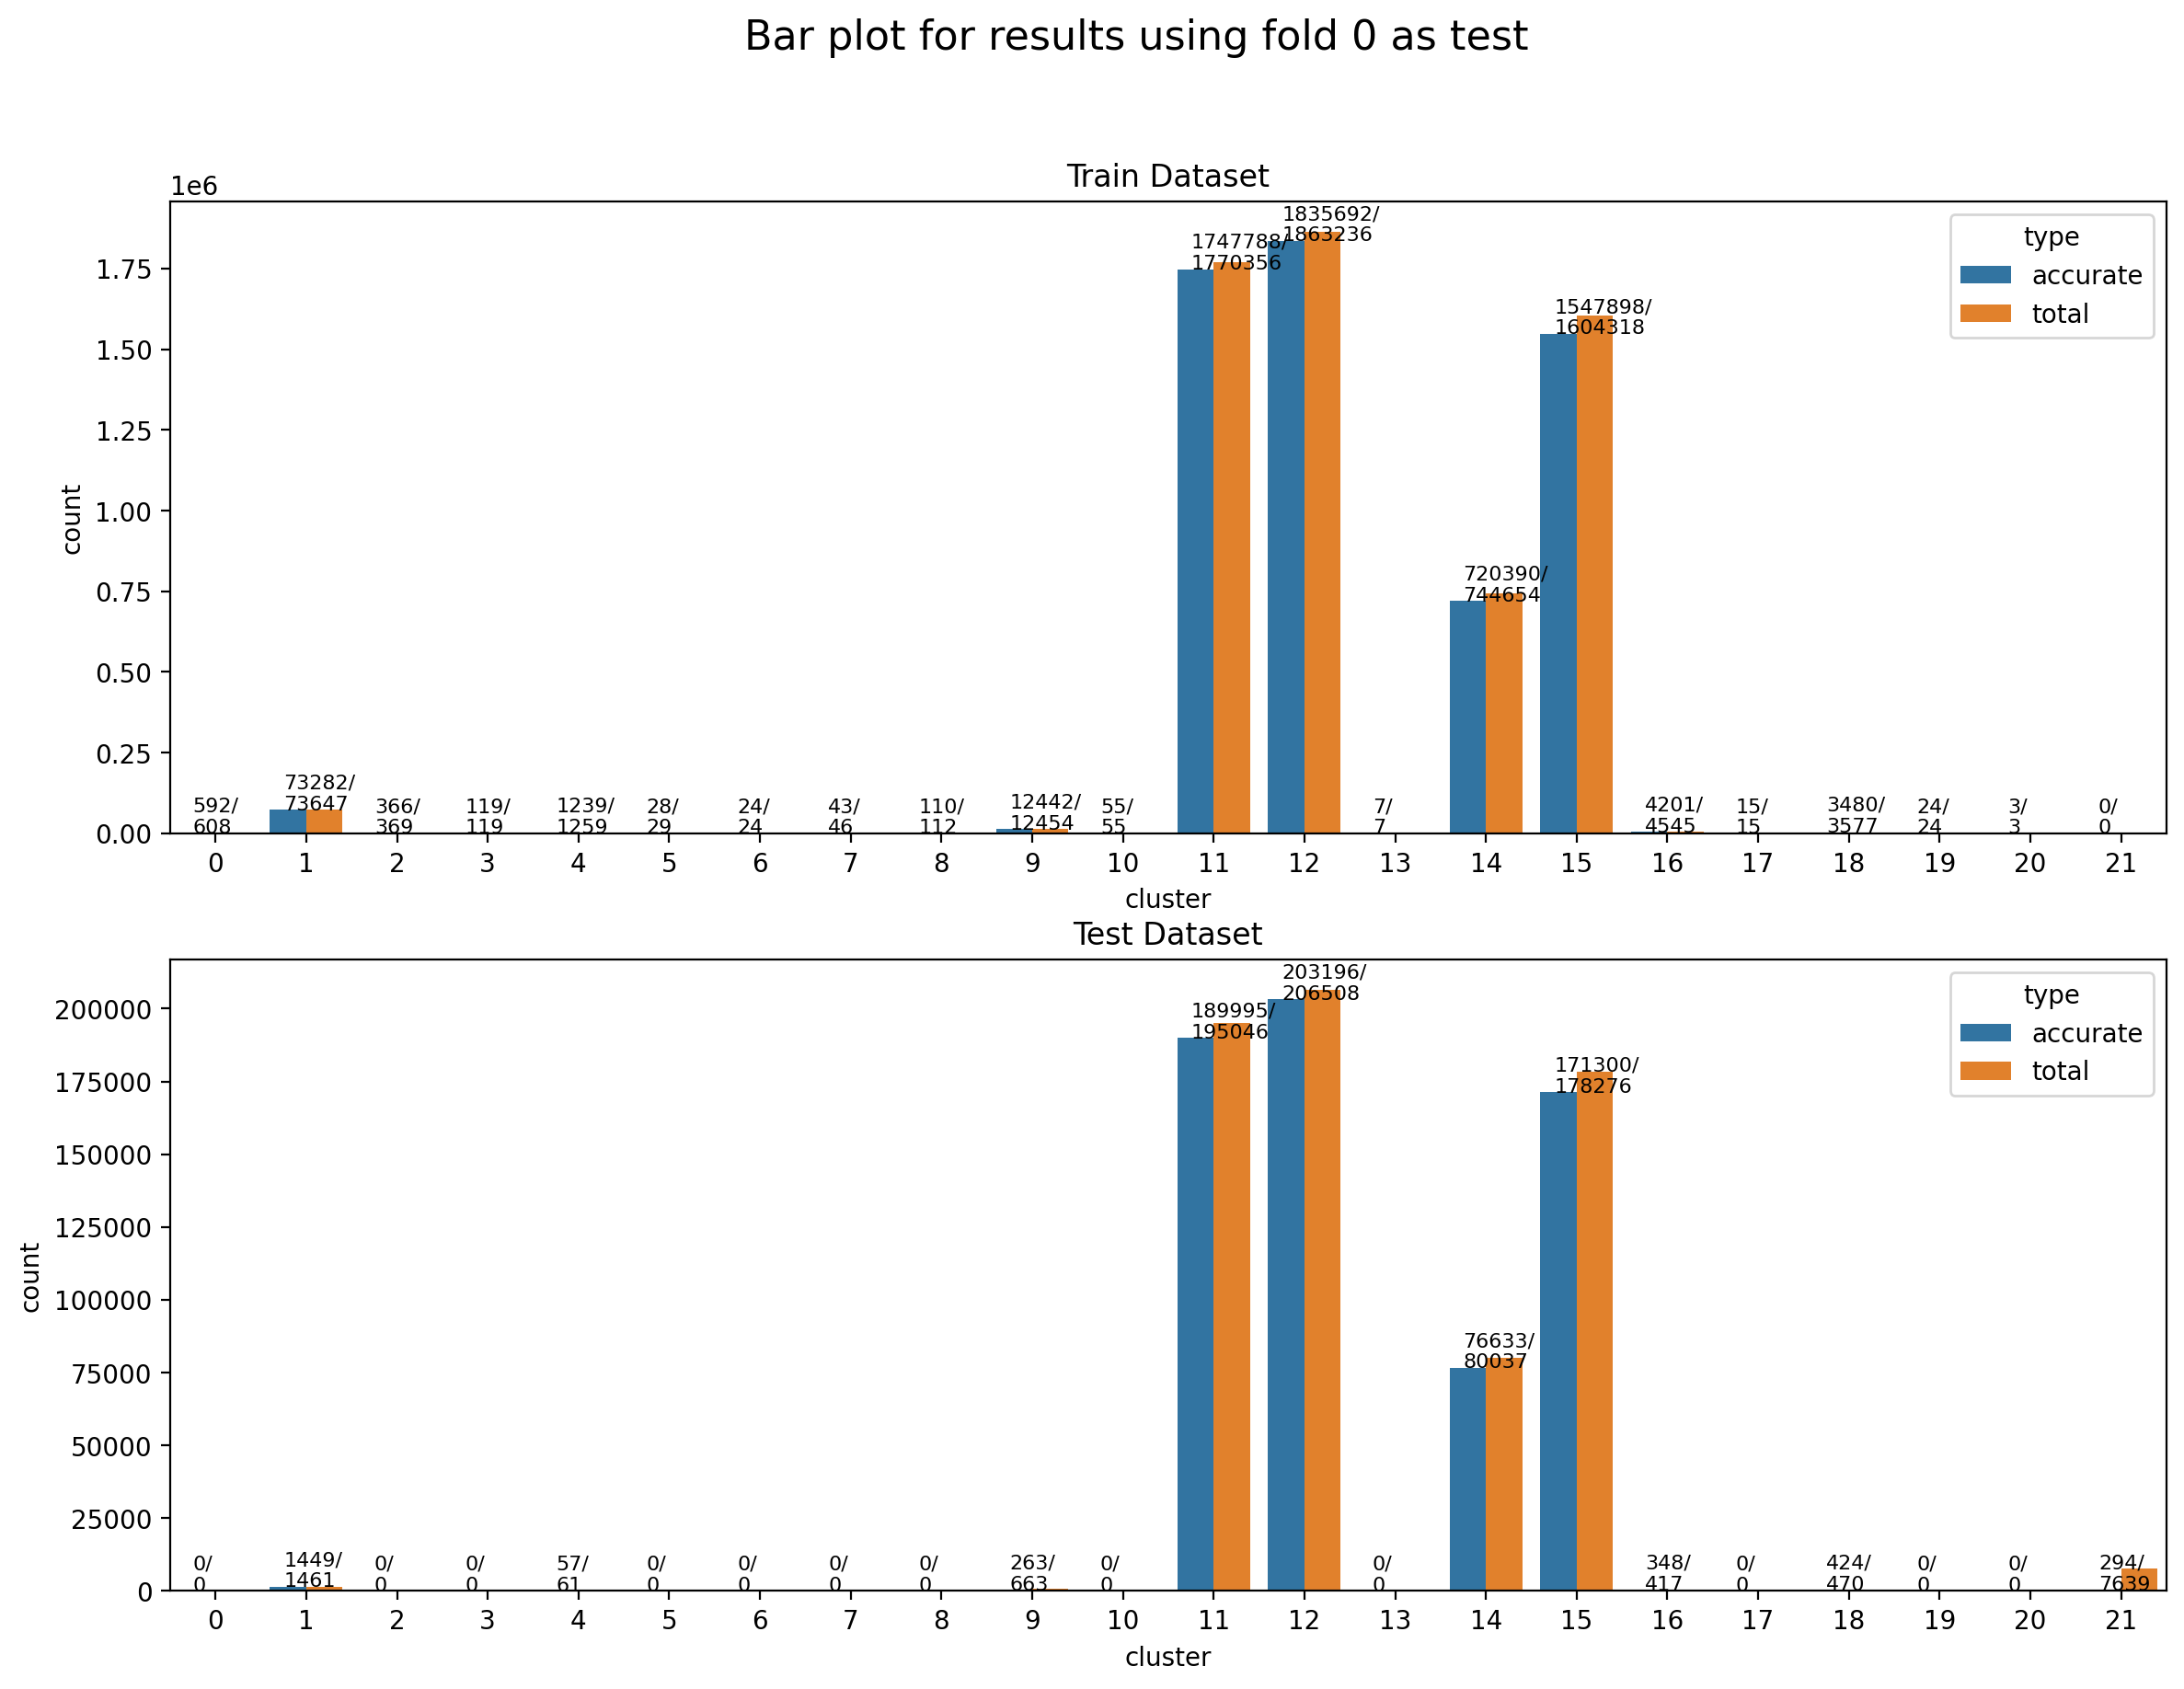

In [5]:
fold = 0
n = len(total_train_list[fold])
acc_train_df = pd.DataFrame({'type': ['accurate']*(n+1)+['total']*(n+1),
                             'count': acc_train_list[fold]+[0]+total_train_list[fold]+[0],
                             'cluster':[i for i in range(n+1)]*2
                            })
acc_test_df = pd.DataFrame({'type': ['accurate']*(n+1)+['total']*(n+1),
                            'count': acc_test_list[fold][:n]+[0]+total_test_list[fold][:n]+[0],
                            'cluster':[i for i in range(n+1)]*2
                           })
if n != len(total_test_list[fold]):
    acc_test_df.loc[:, 'count'] = acc_test_list[fold]+total_test_list[fold]
# plot
fig, ax = plt.subplots(2,1, figsize=(14,10), dpi=200)
fig.suptitle('Bar plot for results using fold {} as test'.format(fold), fontsize=16)
sns.barplot(x='cluster', y='count', hue='type', data=acc_train_df, ax=ax[0])
sns.barplot(x='cluster', y='count', hue='type', data=acc_test_df, ax=ax[1])
for i, v in enumerate(acc_train_df.loc[:n,'count']):
    ax[0].text(i-0.25, v, str(v)+'/\n'+str(acc_train_df.loc[i+n+1,'count']), fontsize=8)
ax[0].set(title='Train Dataset')
for i, v in enumerate(acc_test_df.loc[:n,'count']):
    ax[1].text(i-0.25, v, str(v)+'/\n'+str(acc_test_df.loc[i+n+1,'count']), fontsize=8)
ax[1].set(title='Test Dataset')
plt.show()

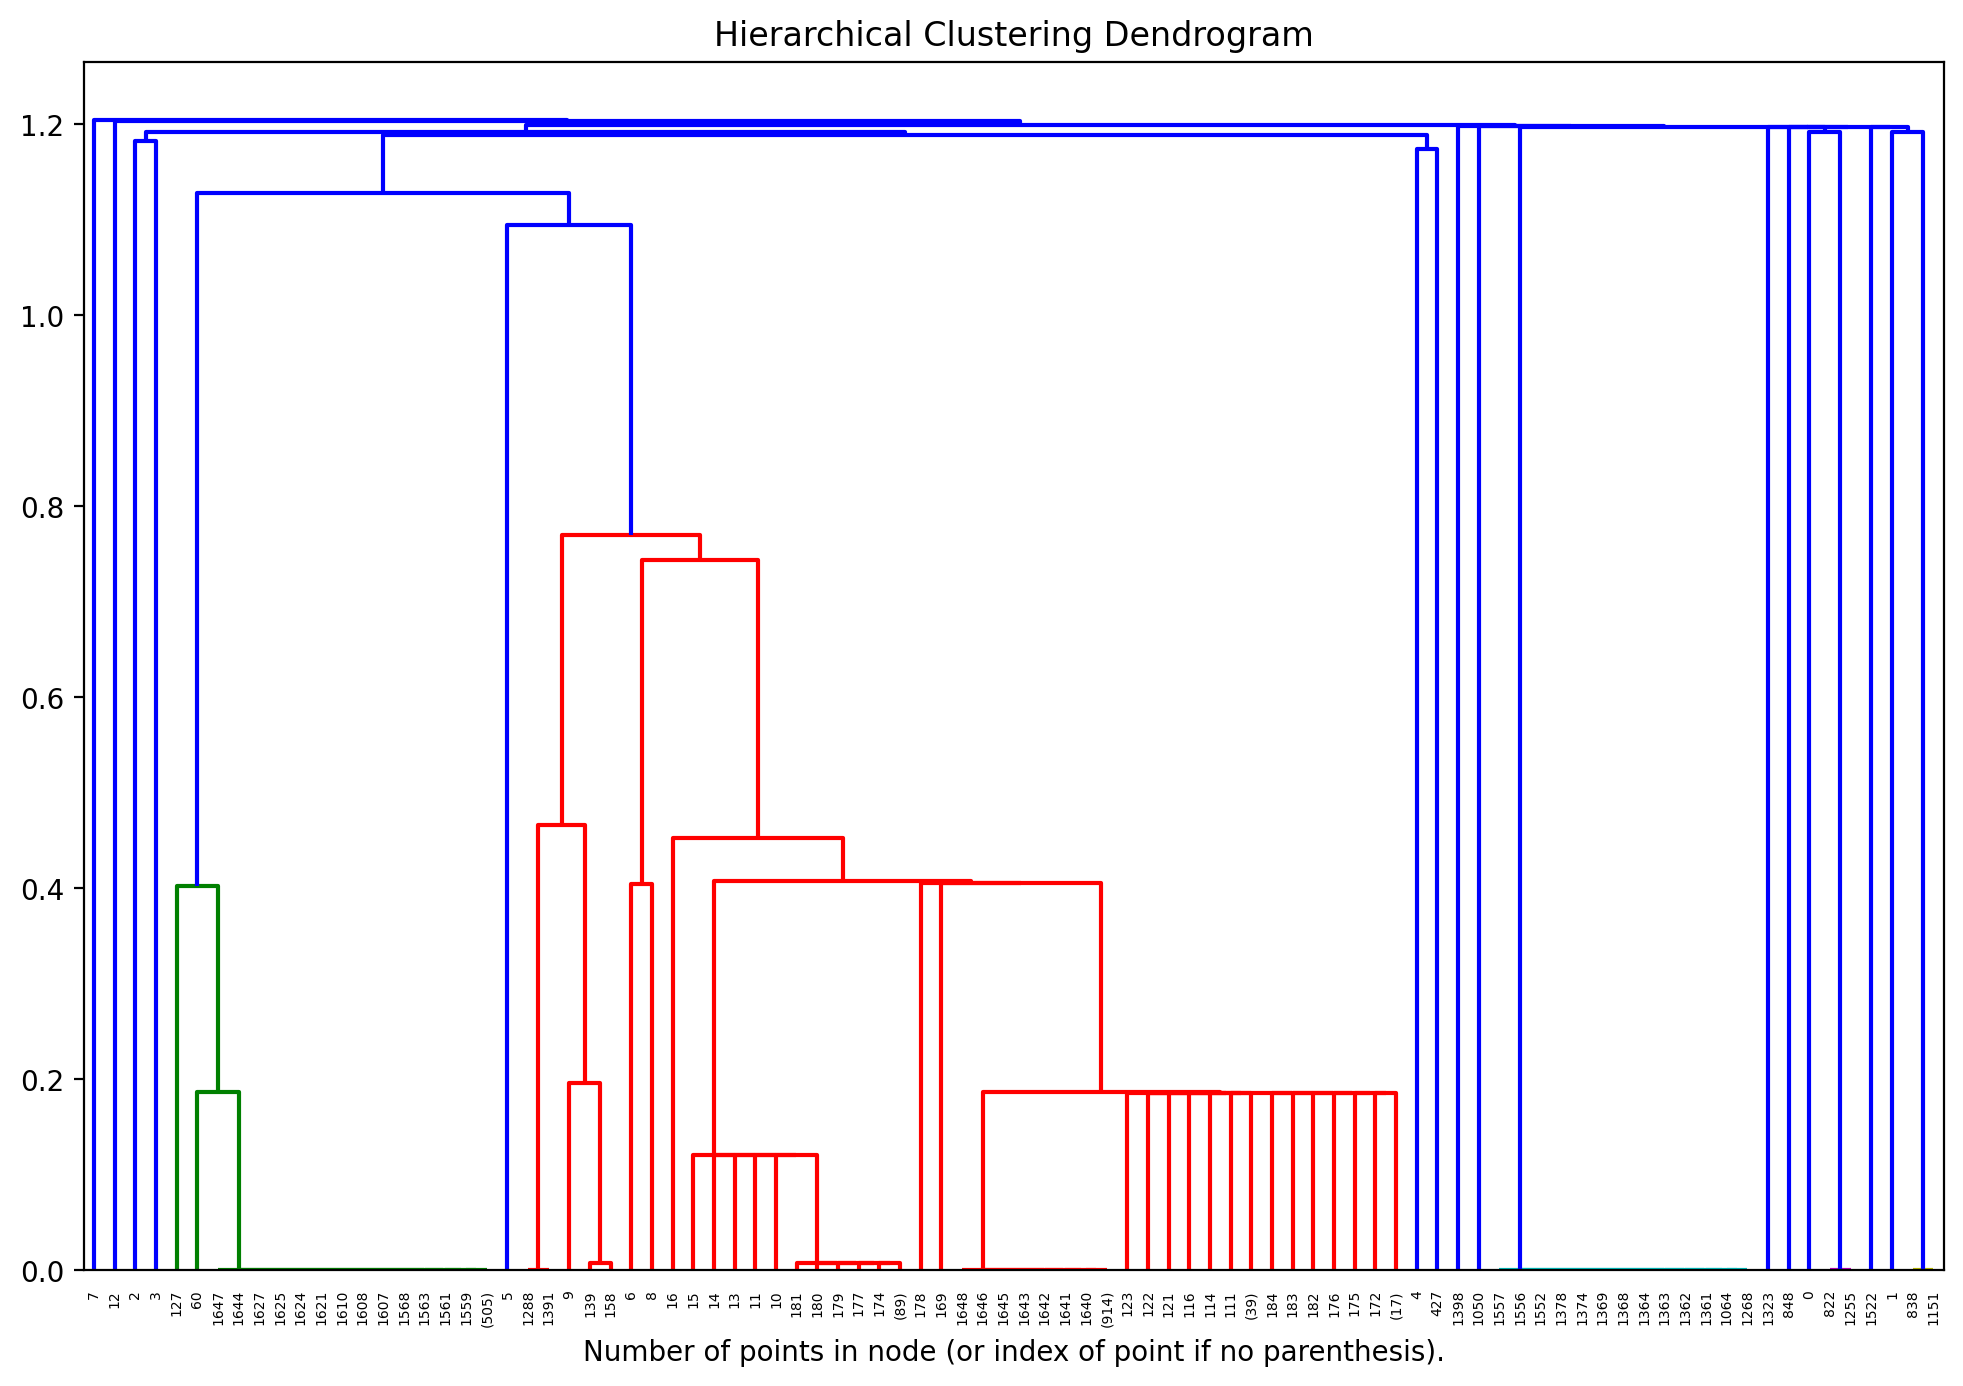

In [11]:
fig, ax = plt.subplots(figsize=(12,8), dpi=200)
plt.title('Hierarchical Clustering Dendrogram')
# plot the top three levels of the dendrogram
plot_dendrogram(clustering[fold], truncate_mode='level', p=20, ax=ax)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

### 6-grams, 1 initial command

We cluster by rank of 6-grams and based on the very first initial command of the sessions.

Alpha for multinomial dirichlet is 0.1.

In [11]:
# alpha=0.1
# n_splits=10
# seq_len=6
# init_len=1
# memory = my_agglomerativeclustering(msdat, alpha, n_splits, seq_len, init_len)
# memory['alpha']=alpha
# memory['n_splits']=n_splits
# memory['seq_len']=seq_len
# memory['init_len']=init_len
# with open('data/aggclustering_memory_6gram.pkl', 'wb') as f:
#     pickle.dump(memory, f)

Round 1/10, start clustering. 24 clusters exist
1 clusters completed, 249.81 seconds spent, train accuracy0.99, test accuracy0.98
11 clusters completed, 251.64 seconds spent, train accuracy1.00, test accuracy0.81
21 clusters completed, 1134.52 seconds spent, train accuracy0.98, test accuracy0.97
Round 1/10 completed, 1135.43 seconds spent, train accuracy0.98, test accuracy0.96
Round 2/10, start clustering. 23 clusters exist
1 clusters completed, 247.15 seconds spent, train accuracy0.99, test accuracy0.98
11 clusters completed, 249.13 seconds spent, train accuracy1.00, test accuracy0.96
21 clusters completed, 1098.82 seconds spent, train accuracy0.98, test accuracy0.97
Round 2/10 completed, 1099.84 seconds spent, train accuracy0.98, test accuracy0.97
Round 3/10, start clustering. 23 clusters exist
1 clusters completed, 249.51 seconds spent, train accuracy0.99, test accuracy0.98
11 clusters completed, 251.50 seconds spent, train accuracy1.00, test accuracy0.97
21 clusters completed, 1115

In [12]:
with open('data/aggclustering_memory_6gram.pkl', 'rb') as f:
    memory = pickle.load(f)
alpha = memory['alpha']
n_splits = memory['n_splits']
seq_len = memory['seq_len']
init_len = memory['init_len']
acc_train_list = memory['acc_train_list'] 
acc_test_list = memory['acc_test_list'] 
total_train_list = memory['total_train_list'] 
total_test_list = memory['total_test_list'] 
clustering = memory['clustering'] 
init_commands_list = memory['init_commands_list']
train_sessions_labels = memory['train_sessions_labels']
test_sessions_labels = memory['test_sessions_labels']

In [13]:
acc_train = sum([sum(i) for i in acc_train_list])/sum([sum(j) for j in total_train_list])
acc_test = sum([sum(i) for i in acc_test_list])/sum([sum(j) for j in total_test_list])

print('10-fold train/test accuracy is {:.2f}%/{:.2f}%'.format(acc_train*100, acc_test*100))

10-fold train/test accuracy is 97.59%/96.40%


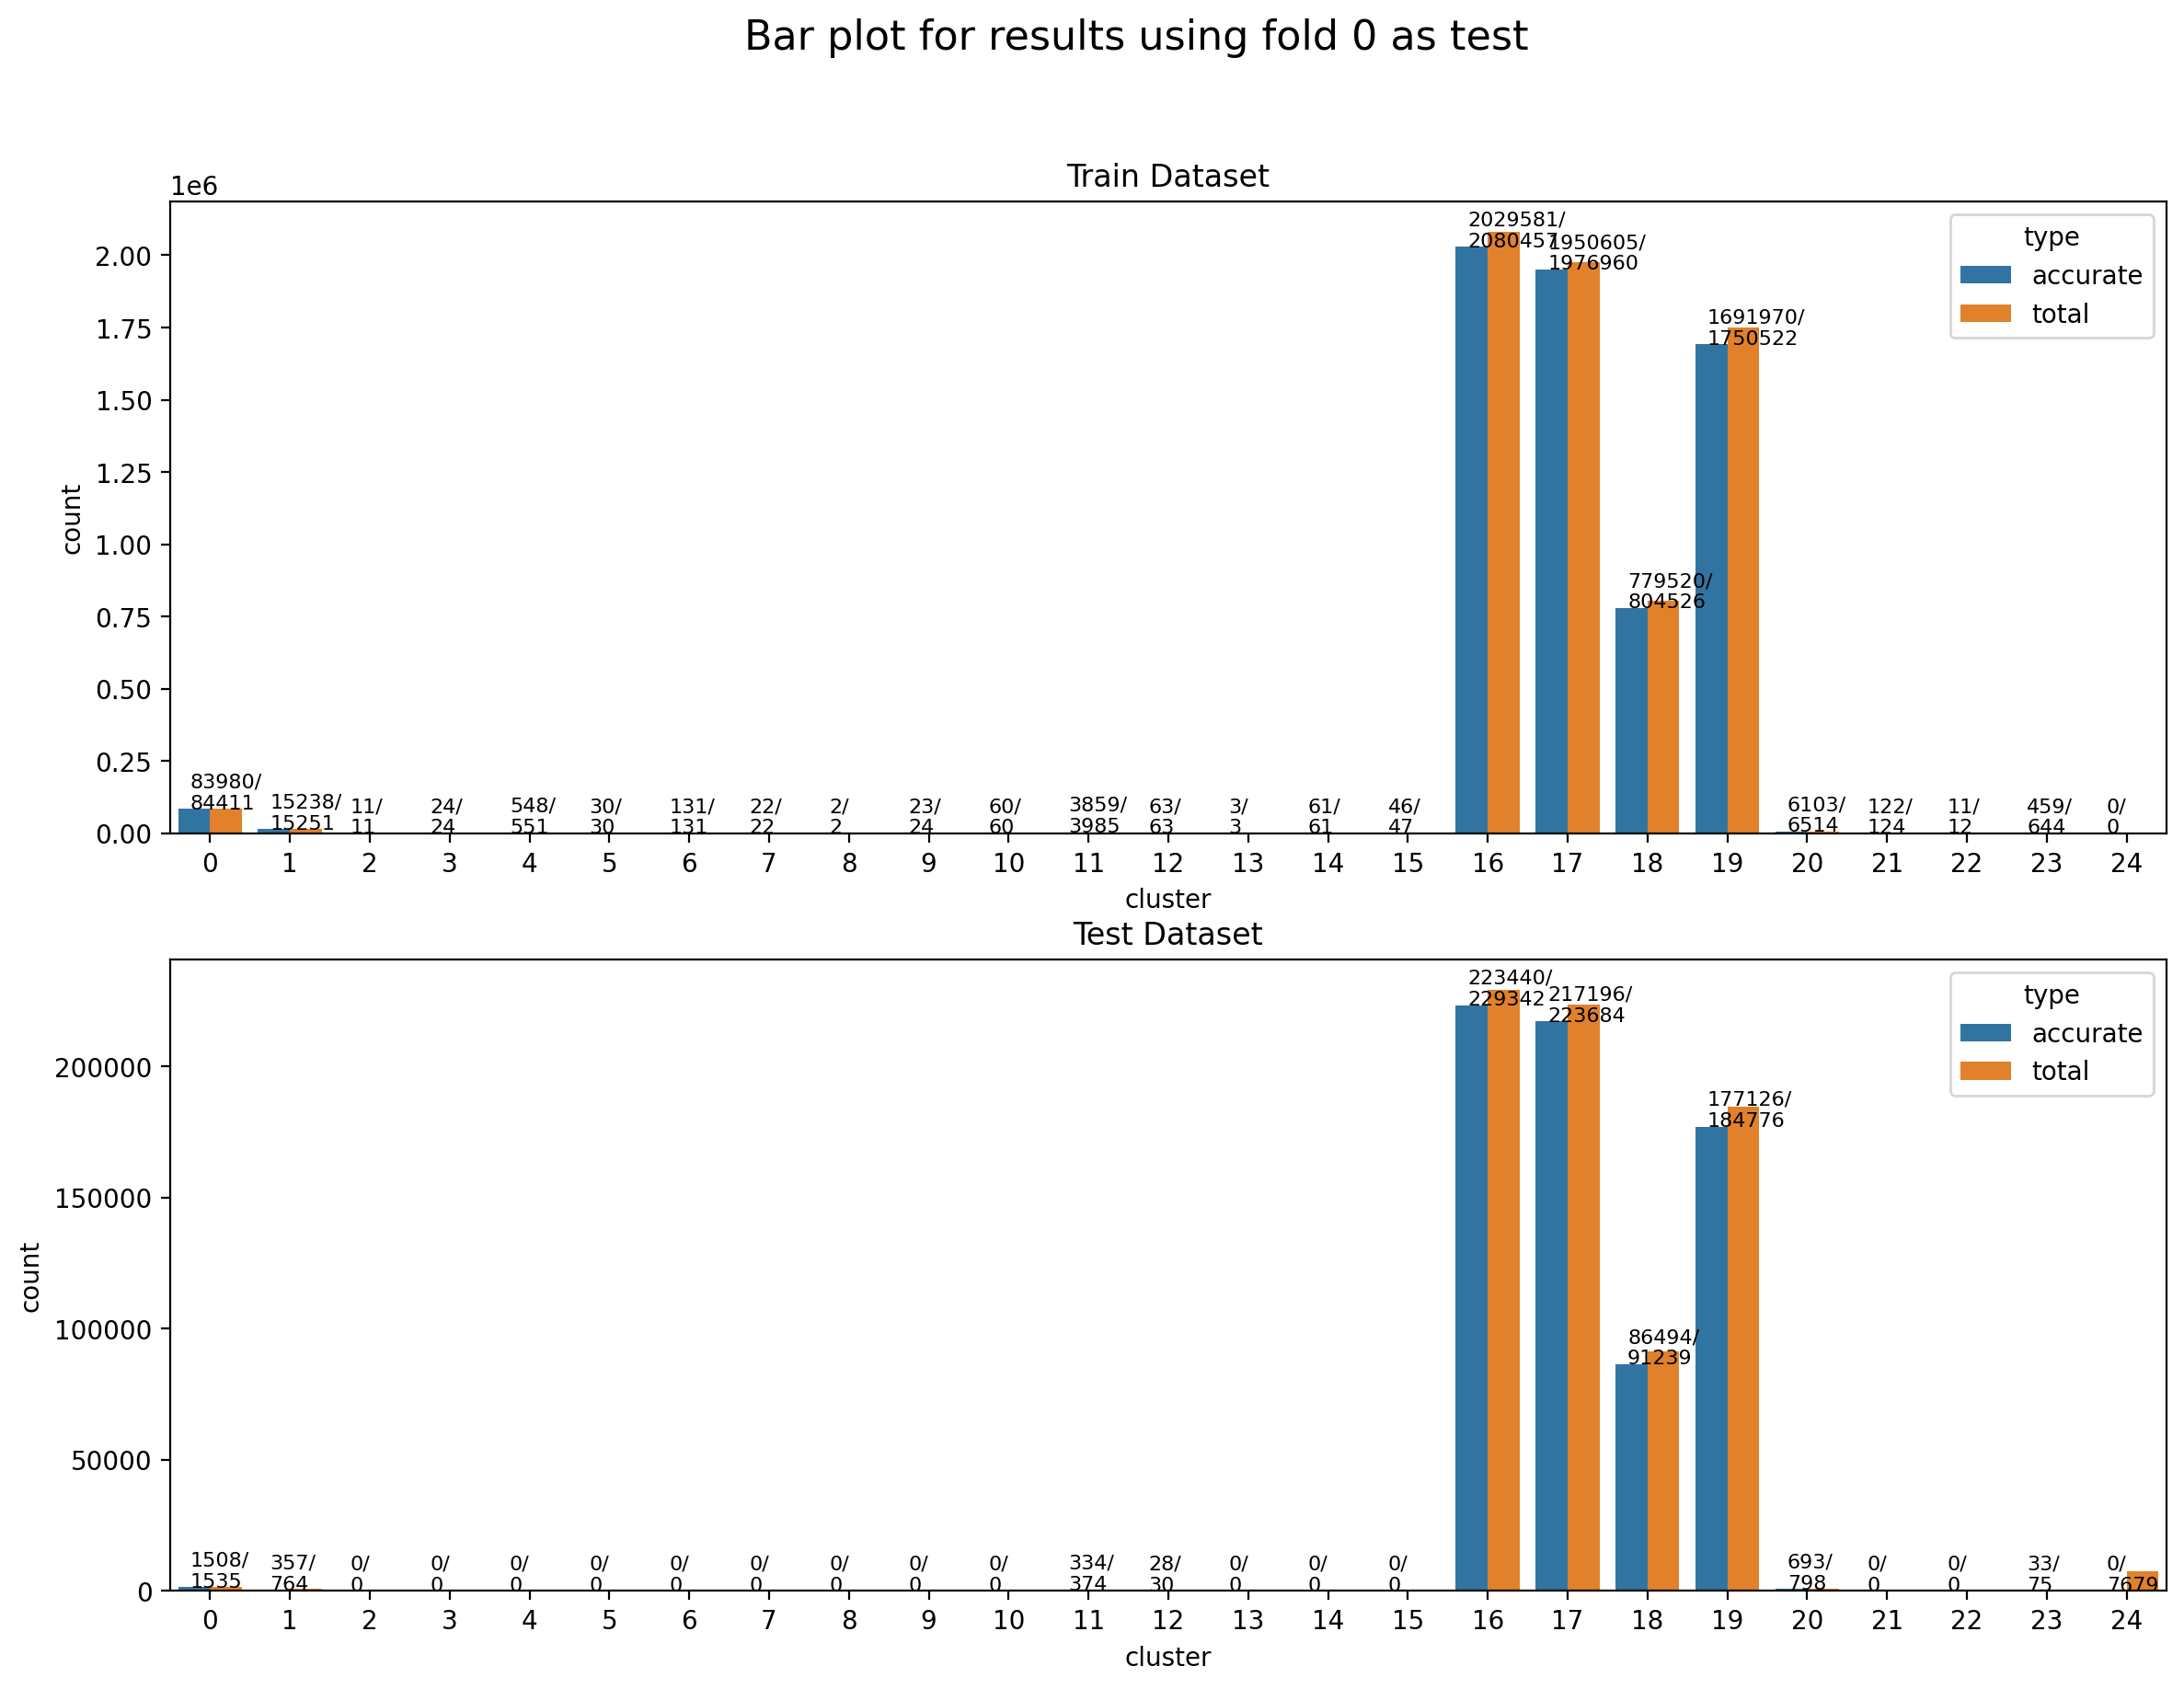

In [14]:
fold = 0
n = len(total_train_list[fold])
acc_train_df = pd.DataFrame({'type': ['accurate']*(n+1)+['total']*(n+1),
                             'count': acc_train_list[fold]+[0]+total_train_list[fold]+[0],
                             'cluster':[i for i in range(n+1)]*2
                            })
acc_test_df = pd.DataFrame({'type': ['accurate']*(n+1)+['total']*(n+1),
                            'count': acc_test_list[fold][:n]+[0]+total_test_list[fold][:n]+[0],
                            'cluster':[i for i in range(n+1)]*2
                           })
if n != len(total_test_list[fold]):
    acc_test_df.loc[:, 'count'] = acc_test_list[fold]+total_test_list[fold]
# plot
fig, ax = plt.subplots(2,1, figsize=(14,10), dpi=200)
fig.suptitle('Bar plot for results using fold {} as test'.format(fold), fontsize=16)
sns.barplot(x='cluster', y='count', hue='type', data=acc_train_df, ax=ax[0])
sns.barplot(x='cluster', y='count', hue='type', data=acc_test_df, ax=ax[1])
for i, v in enumerate(acc_train_df.loc[:n,'count']):
    ax[0].text(i-0.25, v, str(v)+'/\n'+str(acc_train_df.loc[i+n+1,'count']), fontsize=8)
ax[0].set(title='Train Dataset')
for i, v in enumerate(acc_test_df.loc[:n,'count']):
    ax[1].text(i-0.25, v, str(v)+'/\n'+str(acc_test_df.loc[i+n+1,'count']), fontsize=8)
ax[1].set(title='Test Dataset')
plt.show()

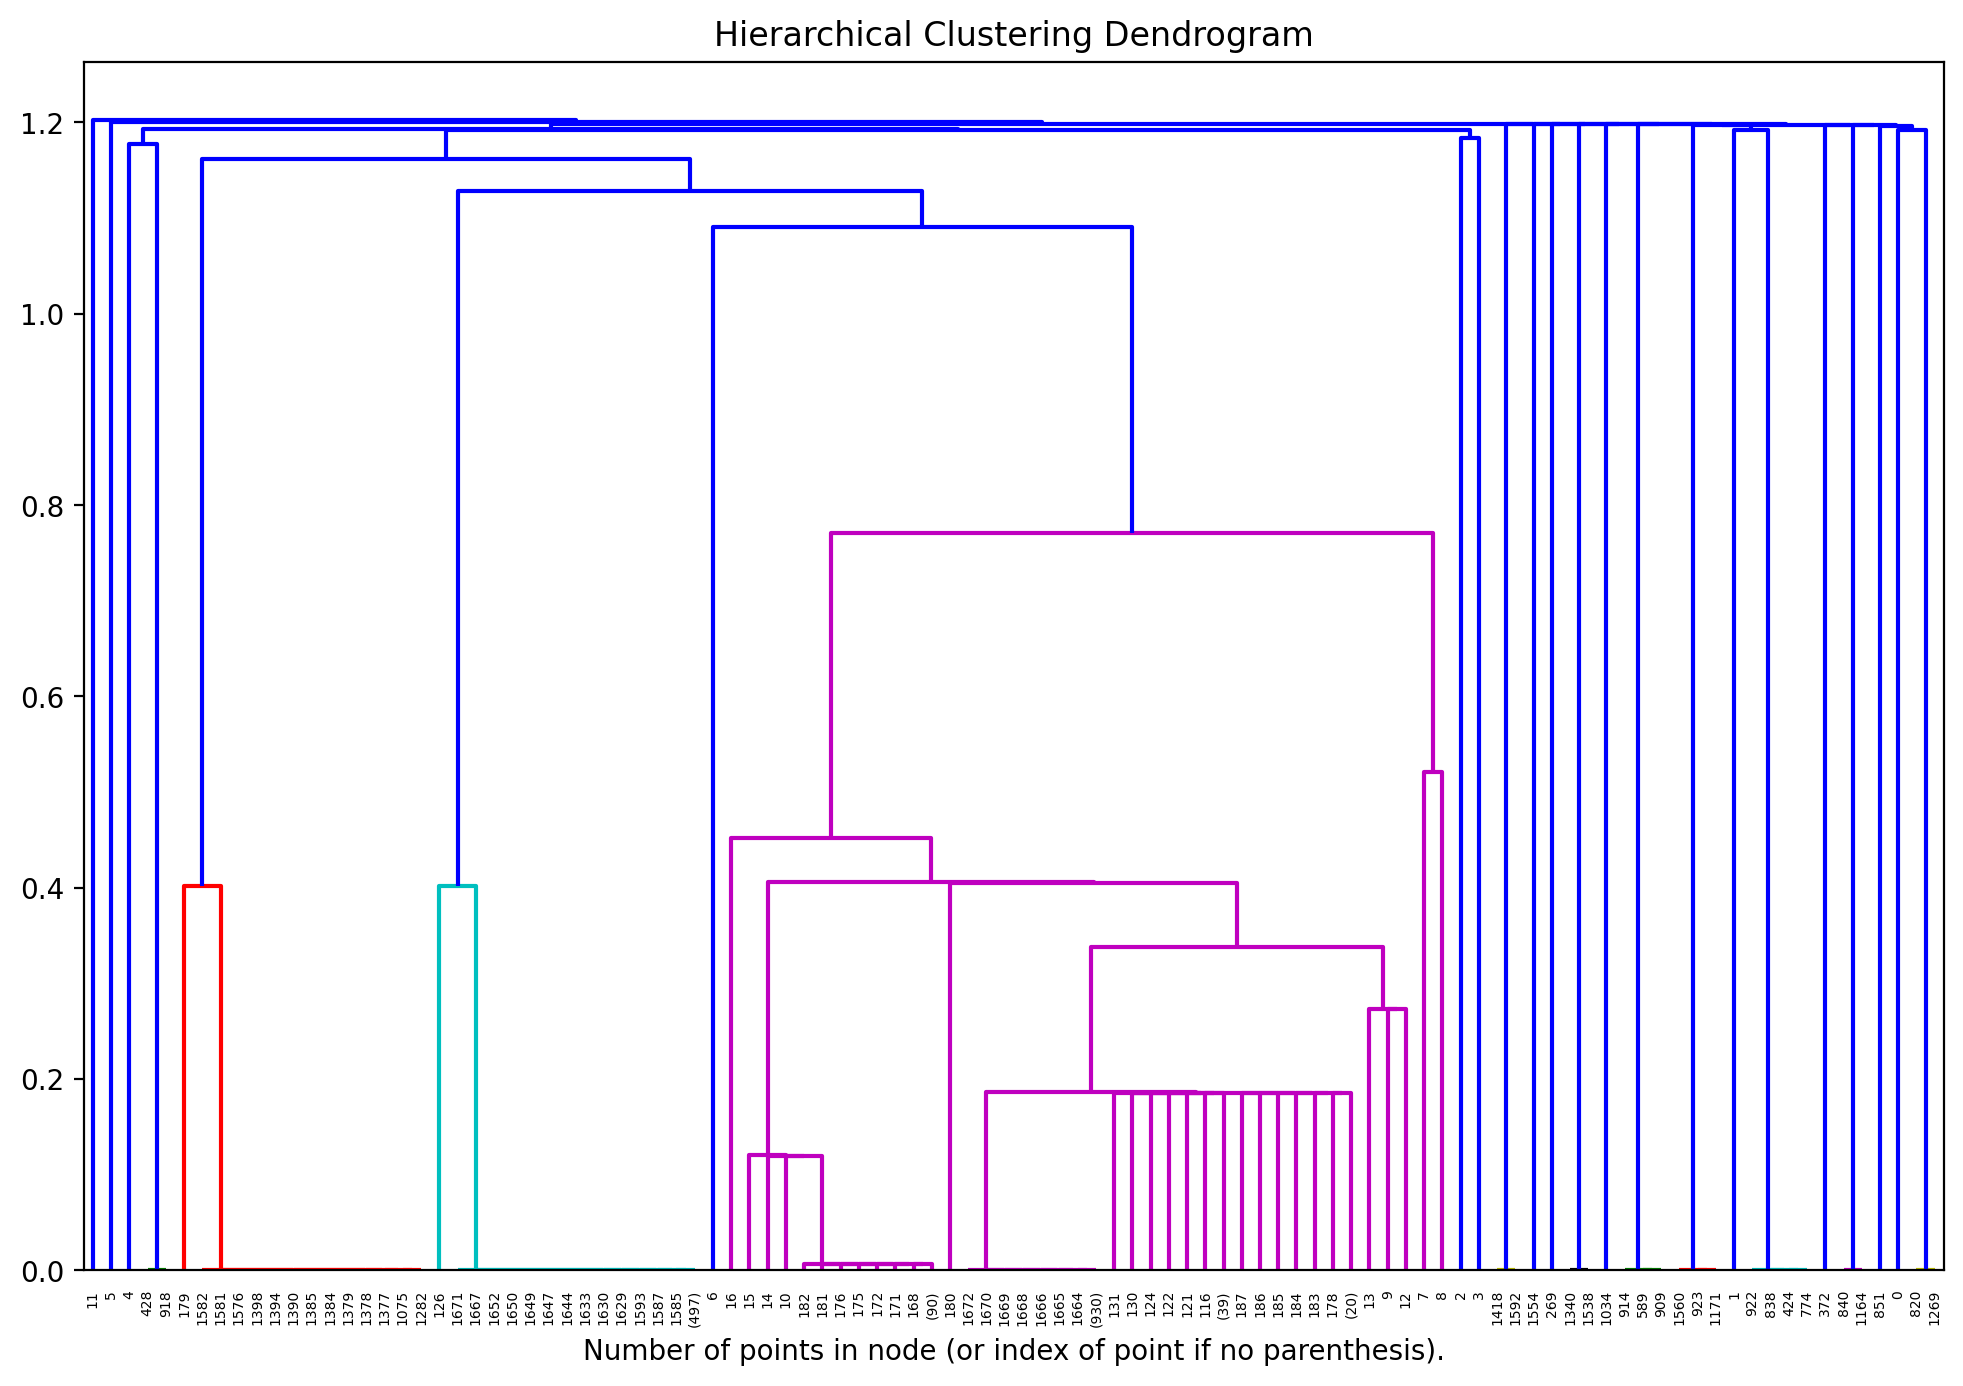

In [15]:
fig, ax = plt.subplots(figsize=(12,8), dpi=200)
plt.title('Hierarchical Clustering Dendrogram')
# plot the top three levels of the dendrogram
plot_dendrogram(clustering[0], truncate_mode='level', p=20, ax=ax)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

### 12-grams, 2 initial commands

We cluster by rank of 12-grams and based on the first two initial commands of the sessions.

Alpha for multinomial dirichlet is 0.1.

In [12]:
# alpha=0.1
# n_splits=10
# seq_len=12
# init_len=2
# memory = my_agglomerativeclustering(msdat, alpha, n_splits, seq_len, init_len)
# memory['alpha']=alpha
# memory['n_splits']=n_splits
# memory['seq_len']=seq_len
# memory['init_len']=init_len
# with open('data/aggclustering_memory_2init.pkl', 'wb') as f:
#     pickle.dump(memory, f)

Round 1/10, start clustering. 64 clusters exist
1 clusters completed, 1565.25 seconds spent, train accuracy0.94, test accuracy0.93
11 clusters completed, 1643.51 seconds spent, train accuracy0.98, test accuracy0.95
21 clusters completed, 1644.44 seconds spent, train accuracy0.98, test accuracy0.95
31 clusters completed, 1645.85 seconds spent, train accuracy0.98, test accuracy0.95
41 clusters completed, 2094.51 seconds spent, train accuracy0.98, test accuracy0.98
51 clusters completed, 2204.76 seconds spent, train accuracy0.98, test accuracy0.97
61 clusters completed, 2209.25 seconds spent, train accuracy0.98, test accuracy0.97
Round 1/10 completed, 2444.40 seconds spent, train accuracy0.98, test accuracy0.95
Round 2/10, start clustering. 68 clusters exist
1 clusters completed, 1551.98 seconds spent, train accuracy0.94, test accuracy0.93
11 clusters completed, 1651.03 seconds spent, train accuracy0.98, test accuracy0.97
21 clusters completed, 1660.79 seconds spent, train accuracy0.98, t

In [17]:
with open('data/aggclustering_memory_2init.pkl', 'rb') as f:
    memory = pickle.load(f)
alpha = memory['alpha']
n_splits = memory['n_splits']
seq_len = memory['seq_len']
init_len = memory['init_len']
acc_train_list = memory['acc_train_list'] 
acc_test_list = memory['acc_test_list'] 
total_train_list = memory['total_train_list'] 
total_test_list = memory['total_test_list'] 
clustering = memory['clustering'] 
init_commands_list = memory['init_commands_list']
train_sessions_labels = memory['train_sessions_labels']
test_sessions_labels = memory['test_sessions_labels']

In [18]:
acc_train = sum([sum(i) for i in acc_train_list])/sum([sum(j) for j in total_train_list])
acc_test = sum([sum(i) for i in acc_test_list])/sum([sum(j) for j in total_test_list])

print('10-fold train/test accuracy is {:.2f}%/{:.2f}%'.format(acc_train*100, acc_test*100))

10-fold train/test accuracy is 98.06%/94.24%


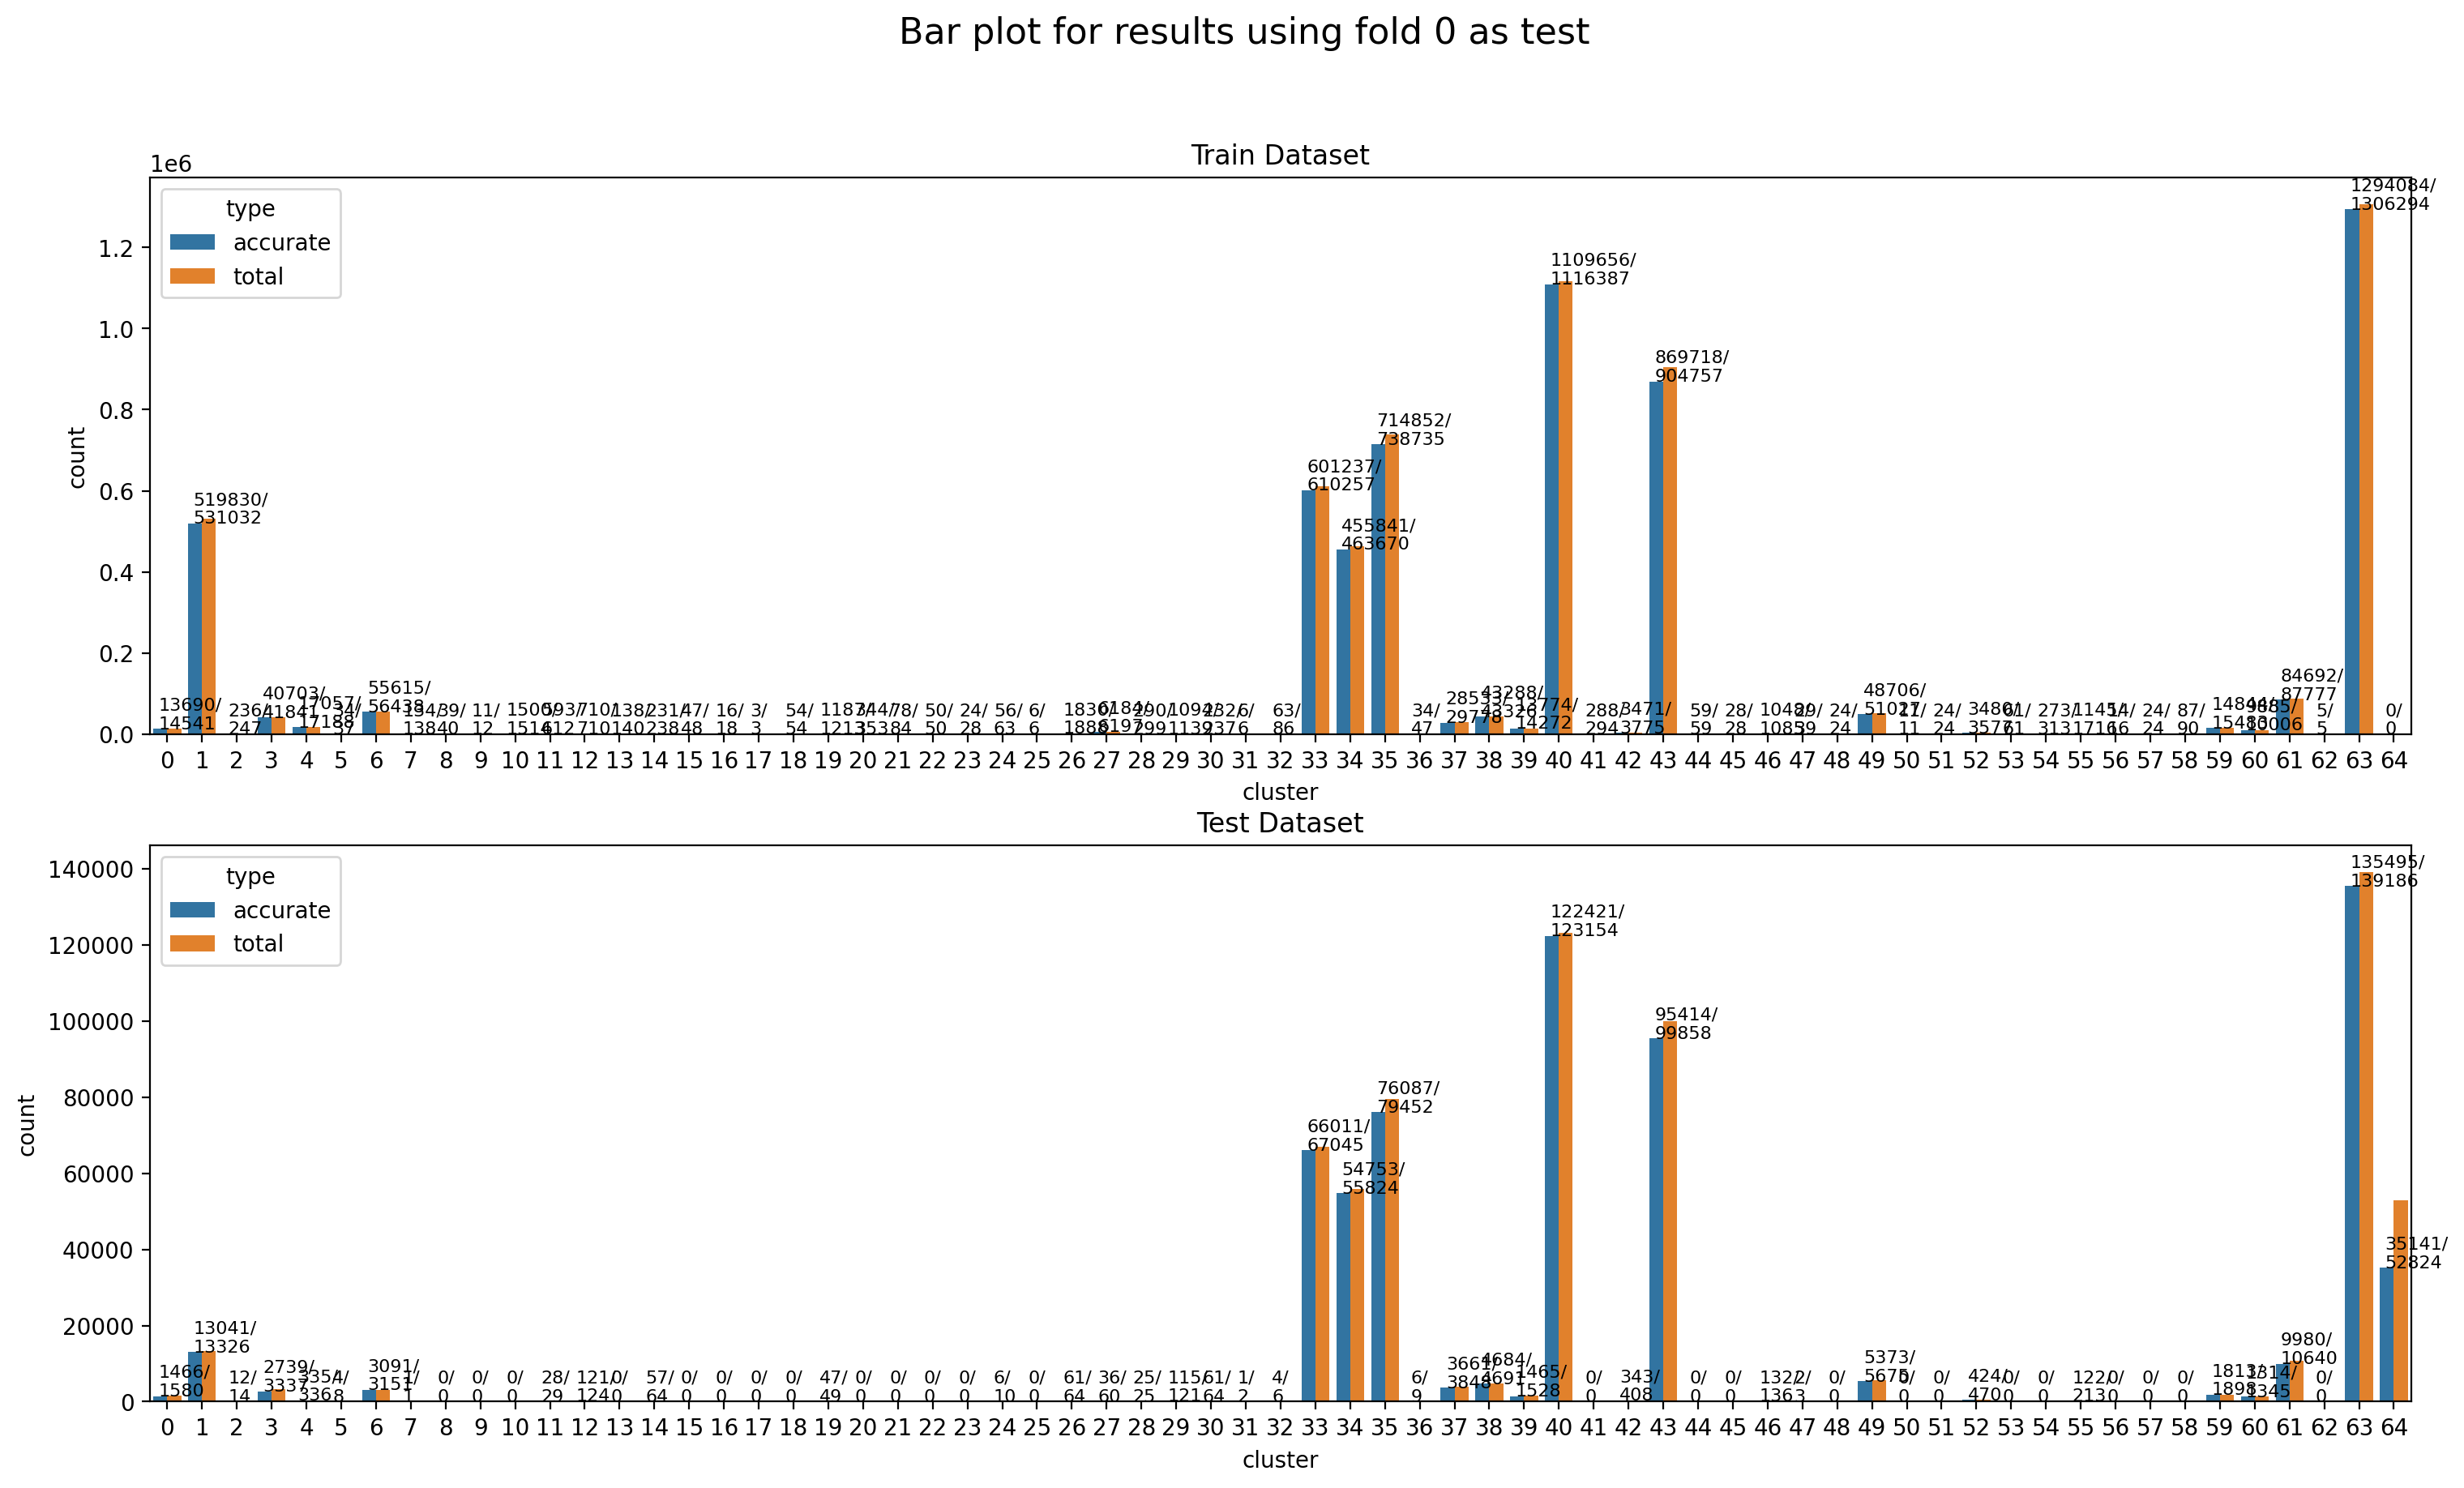

In [19]:
fold = 0
n = len(total_train_list[fold])
acc_train_df = pd.DataFrame({'type': ['accurate']*(n+1)+['total']*(n+1),
                             'count': acc_train_list[fold]+[0]+total_train_list[fold]+[0],
                             'cluster':[i for i in range(n+1)]*2
                            })
acc_test_df = pd.DataFrame({'type': ['accurate']*(n+1)+['total']*(n+1),
                            'count': acc_test_list[fold][:n]+[0]+total_test_list[fold][:n]+[0],
                            'cluster':[i for i in range(n+1)]*2
                           })
if n != len(total_test_list[fold]):
    acc_test_df.loc[:, 'count'] = acc_test_list[fold]+total_test_list[fold]
# plot
fig, ax = plt.subplots(2,1, figsize=(18,10), dpi=200)
fig.suptitle('Bar plot for results using fold {} as test'.format(fold), fontsize=16)
sns.barplot(x='cluster', y='count', hue='type', data=acc_train_df, ax=ax[0])
sns.barplot(x='cluster', y='count', hue='type', data=acc_test_df, ax=ax[1])
for i, v in enumerate(acc_train_df.loc[:n,'count']):
    ax[0].text(i-0.25, v, str(v)+'/\n'+str(acc_train_df.loc[i+n+1,'count']), fontsize=8)
ax[0].set(title='Train Dataset')
for i, v in enumerate(acc_test_df.loc[:n,'count']):
    ax[1].text(i-0.25, v, str(v)+'/\n'+str(acc_test_df.loc[i+n+1,'count']), fontsize=8)
ax[1].set(title='Test Dataset')
plt.show()

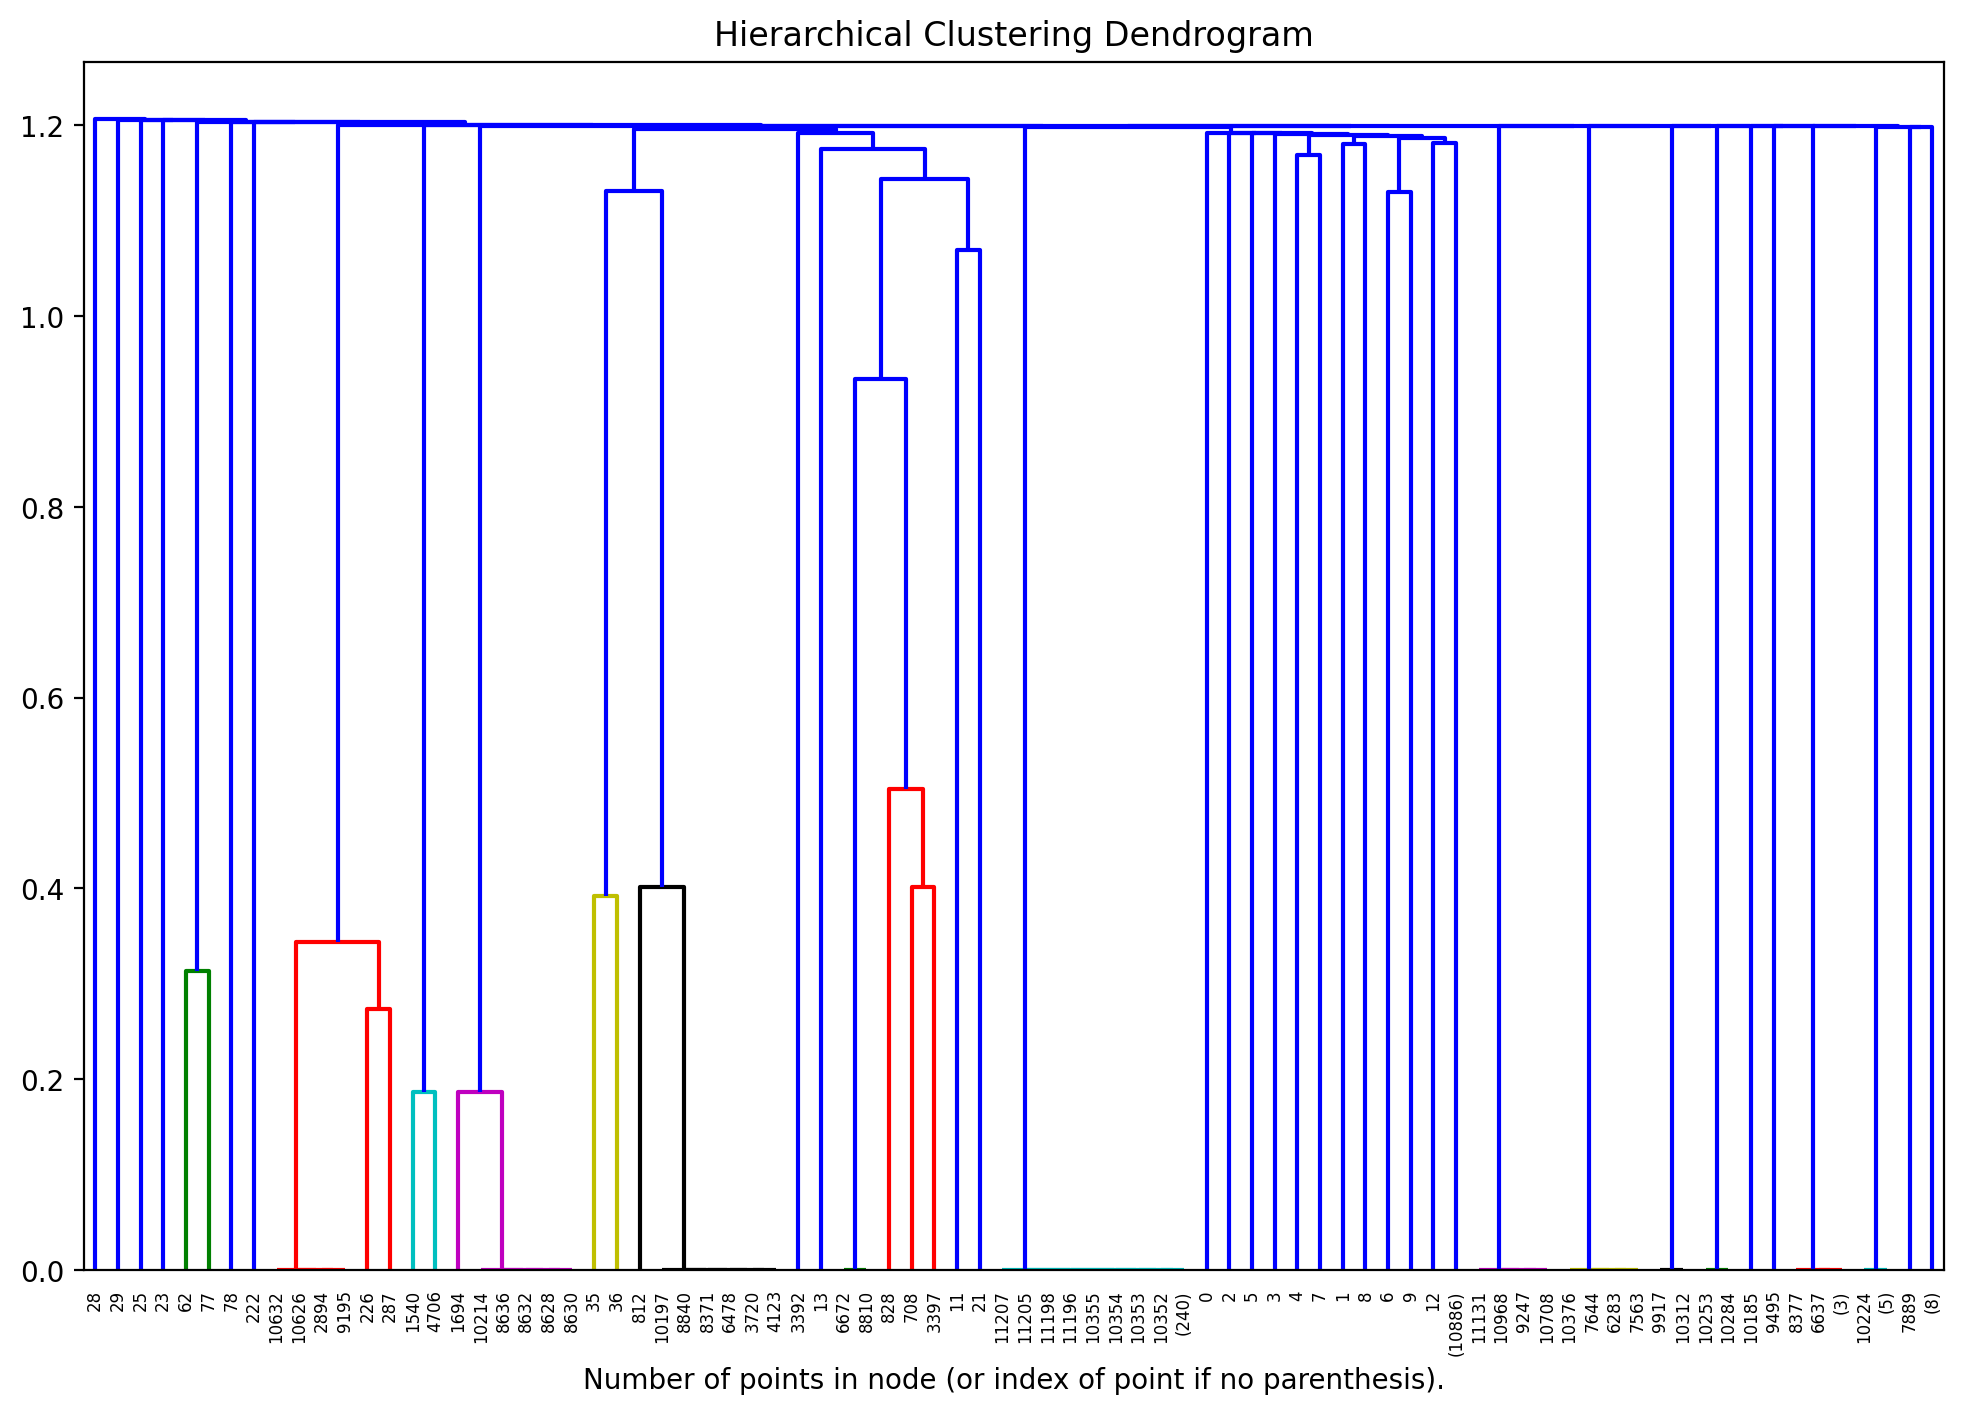

In [20]:
fig, ax = plt.subplots(figsize=(12,8), dpi=200)
plt.title('Hierarchical Clustering Dendrogram')
# plot the top three levels of the dendrogram
plot_dendrogram(clustering[0], truncate_mode='level', p=20, ax=ax)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()